In [5]:
from util import get_num_lines, get_pos2idx_idx2pos, index_sequence, get_vocab, embed_indexed_sequence, \
    get_word2idx_idx2word, get_embedding_matrix, write_predictions, get_performance_VUAverb_val
from util import TextDatasetWithGloveElmoSuffix as TextDataset
from util import evaluate
from model import RNNSequenceModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import csv
import h5py
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [6]:
print("PyTorch version:")
print(torch.__version__)
#print("GPU Detected:")
#print(torch.cuda.is_available())
using_GPU = False

PyTorch version:
0.4.1


In [7]:
"""
1. Data pre-processing
"""

'''
1.3 MOH-X
get raw dataset as a list:
  Each element is a triple:
    a sentence: string
    a index: int: idx of the focus verb
    a label: int 1 or 0
'''
raw_mohx = []

with open('../data/MOH-X/MOH-X_formatted_svo_cleaned.csv') as f:
    # arg1  	arg2	verb	sentence	verb_idx	label
    lines = csv.reader(f)
    next(lines)
    for line in lines:
        sentence = line[3]
        label_seq = [0] * len(sentence.split())
        pos_seq = [0] * len(label_seq)
        verb_idx = int(line[4])
        verb_label = int(line[5])
        label_seq[verb_idx] = verb_label
        pos_seq[verb_idx] = 1   # idx2pos = {0: 'words that are not focus verbs', 1: 'focus verb'}
        raw_mohx.append([sentence.strip(), label_seq, pos_seq])


print('MOH-X dataset division: ', len(raw_mohx))




MOH-X dataset division:  647


In [8]:
"""
2. Data preparation
"""
'''
2. 1
get vocabulary and glove embeddings in raw dataset
'''
# vocab is a set of words
vocab = get_vocab(raw_mohx)
# two dictionaries. <PAD>: 0, <UNK>: 1
word2idx, idx2word = get_word2idx_idx2word(vocab)
# glove_embeddings a nn.Embeddings
glove_embeddings = get_embedding_matrix(word2idx, idx2word, normalization=False)
# elmo_embeddings
# set elmos_mohx=None to exclude elmo vectors. Also need to change the embedding_dim in later model initialization
#elmos_mohx = h5py.File('../elmo/MOH-X_cleaned.hdf5', 'r')
elmos_mohx=None
'''
2. 2
embed the datasets
'''
random.seed(0)
random.shuffle(raw_mohx)

# second argument is the post sequence, which we don't need
embedded_mohx = [[embed_indexed_sequence(example[0], example[2], word2idx,
                                      glove_embeddings, elmos_mohx, None),
                       example[2], example[1]]
                      for example in raw_mohx]

'''
2. 3 10-fold cross validation
'''
# separate the embedded_sentences and labels into 2 list, in order to pass into the TextDataset as argument
sentences = [example[0] for example in embedded_mohx]
poss = [example[1] for example in embedded_mohx]
labels = [example[2] for example in embedded_mohx]
# ten_folds is a list of 10 tuples, each tuple is (list_of_embedded_sentences, list_of_corresponding_labels)
ten_folds = []
fold_size = int(647 / 10)
for i in range(10):
    ten_folds.append((sentences[i * fold_size:(i + 1) * fold_size],
                      poss[i * fold_size:(i + 1) * fold_size],
                      labels[i * fold_size:(i + 1) * fold_size]))

idx2pos = {0: 'words that are not focus verbs', 1: 'focus verb'}

optimal_f1s = []
optimal_ps = []
optimal_rs = []
optimal_accs = []
predictions_all = []
for i in range(10):
    '''
    2. 3
    set up Dataloader for batching
    '''
    training_sentences = []
    training_labels = []
    training_poss = []
    for j in range(10):
        if j != i:
            training_sentences.extend(ten_folds[j][0])
            training_poss.extend(ten_folds[j][1])
            training_labels.extend(ten_folds[j][2])
    training_dataset_mohx = TextDataset(training_sentences, training_poss, training_labels)
    val_dataset_mohx = TextDataset(ten_folds[i][0], ten_folds[i][1], ten_folds[i][2])

    # Data-related hyperparameters
    batch_size = 10
    # Set up a DataLoader for the training, validation, and test dataset
    train_dataloader_mohx = DataLoader(dataset=training_dataset_mohx, batch_size=batch_size, shuffle=True,
                                       collate_fn=TextDataset.collate_fn)
    val_dataloader_mohx = DataLoader(dataset=val_dataset_mohx, batch_size=batch_size, shuffle=False,
                                     collate_fn=TextDataset.collate_fn)


vocab size:  1732



 17%|█▋        | 368722/2196017 [00:13<01:12, 25300.81it/s]


 35%|███▌      | 778964/2196017 [00:27<00:48, 29161.75it/s]


 55%|█████▌    | 1213898/2196017 [00:40<00:28, 34390.58it/s]


 75%|███████▌  | 1652307/2196017 [00:54<00:17, 31740.24it/s]


 95%|█████████▌| 2087533/2196017 [01:07<00:03, 33871.03it/s]


100%|██████████| 2196017/2196017 [01:10<00:00, 31223.36it/s]

Number of pre-trained word vectors loaded:  1730
Embeddings mean:  -0.0001946780103025958
Embeddings stdev:  0.3732253909111023


In [35]:
"""
3. Model training
"""
'''
3. 1
set up model, loss criterion, optimizer
'''
    # Instantiate the model
    # embedding_dim = glove + elmo + suffix indicator
    # dropout1: dropout on input to RNN
    # dropout2: dropout in RNN; would be used if num_layers=1
    # dropout3: dropout on hidden state of RNN to linear layer
    
    # with elmo embedding_dim=300+1024
RNNseq_model = RNNSequenceModel(num_classes=2, embedding_dim=300, hidden_size=300, 
                                    num_layers=1, bidir=True,
                                    dropout1=0.5, dropout2=0, dropout3=0)
    # Move the model to the GPU if available
if using_GPU:
    RNNseq_model = RNNseq_model.cuda()
    # Set up criterion for calculating loss
loss_criterion = nn.NLLLoss()
    # Set up an optimizer for updating the parameters of the rnn_clf
rnn_optimizer = optim.Adam(RNNseq_model.parameters(), lr=0.001)
    # Number of epochs (passes through the dataset) to train the model for.
num_epochs = 30
'''
3. 2
train model
'''
train_loss = []
val_loss = []
performance_matrix = None
val_f1 = []
val_p = []
val_r = []
val_acc = []
train_f1 = []
    # A counter for the number of gradient updates
num_iter = 0
model_index = 0
comparable = []
for epoch in range(num_epochs):
    print("Starting epoch {}".format(epoch + 1))
    for (__, example_text, example_lengths, labels) in train_dataloader_mohx:
        example_text = Variable(example_text)
        example_lengths = Variable(example_lengths)
        labels = Variable(labels)
        if using_GPU:
            example_text = example_text.cuda()
            example_lengths = example_lengths.cuda()
            labels = labels.cuda()
            # predicted shape: (batch_size, seq_len, 2)
        predicted = RNNseq_model(example_text, example_lengths)
        batch_loss = loss_criterion(predicted.view(-1, 2), labels.view(-1))
        rnn_optimizer.zero_grad()
        batch_loss.backward()
        rnn_optimizer.step()
        num_iter += 1
            # Calculate validation and training set loss and accuracy every 200 gradient updates
        if num_iter % 50 == 0:
            avg_eval_loss, performance_matrix = evaluate(idx2pos, val_dataloader_mohx, RNNseq_model,
                                                             loss_criterion, using_GPU)
            val_loss.append(avg_eval_loss)
            val_p.append(performance_matrix[1][0])
            val_r.append(performance_matrix[1][1])
            val_f1.append(performance_matrix[1][2])
            val_acc.append(performance_matrix[1][3])
            print("Iteration {}. Validation Loss {}.".format(num_iter, avg_eval_loss))

            avg_eval_loss, performance_matrix = evaluate(idx2pos, train_dataloader_mohx, RNNseq_model,
                                                              loss_criterion, using_GPU)
            train_loss.append(avg_eval_loss)
            train_f1.append(performance_matrix[1][2])
            print("Iteration {}. Training Loss {}.".format(num_iter, avg_eval_loss))
print("Training done for fold {}".format(i))

Starting epoch 1
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb 100.0 3.5714285714285716 6.8965517241379315 57.8125
Iteration 50. Validation Loss 0.32595404982566833.
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb 76.47058823529412 4.577464788732394 8.637873754152823 52.25694444444444
Iteration 50. Training Loss 0.3157672882080078.
Starting epoch 2
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb 57.89473684210526 39.285714285714285 46.808510638297875 60.9375
Iteration 100. Validation Loss 0.2924431264400482.
PRFA performance for  words that are not focus verbs 0.0 nan nan 99.90071978158352
PRFA performance for  focus verb 81.28342245989305 53.521126760563384 64.54352441613587 71.00694444444444
Iteration 100. Training Loss 0.2783869802951813.
Starting epoch 3
PRFA performance for  words that are not focus verbs 0.0 nan 

PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb 100.0 98.94366197183099 99.46902654867257 99.47916666666667
Iteration 900. Training Loss 0.08433772623538971.
Starting epoch 17
PRFA performance for  words that are not focus verbs 0.0 nan nan 99.56140350877193
PRFA performance for  focus verb 62.96296296296296 60.714285714285715 61.81818181818181 67.1875
Iteration 950. Validation Loss 0.19771787524223328.
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb 98.60627177700349 99.64788732394366 99.12434325744309 99.13194444444444
Iteration 950. Training Loss 0.08024425804615021.
Starting epoch 18
PRFA performance for  words that are not focus verbs 0.0 nan nan 99.56140350877193
PRFA performance for  focus verb 67.85714285714286 67.85714285714286 67.85714285714286 71.875
Iteration 1000. Validation Loss 0.1819457858800888.
PRFA performance for  words that are not focus verbs nan nan nan

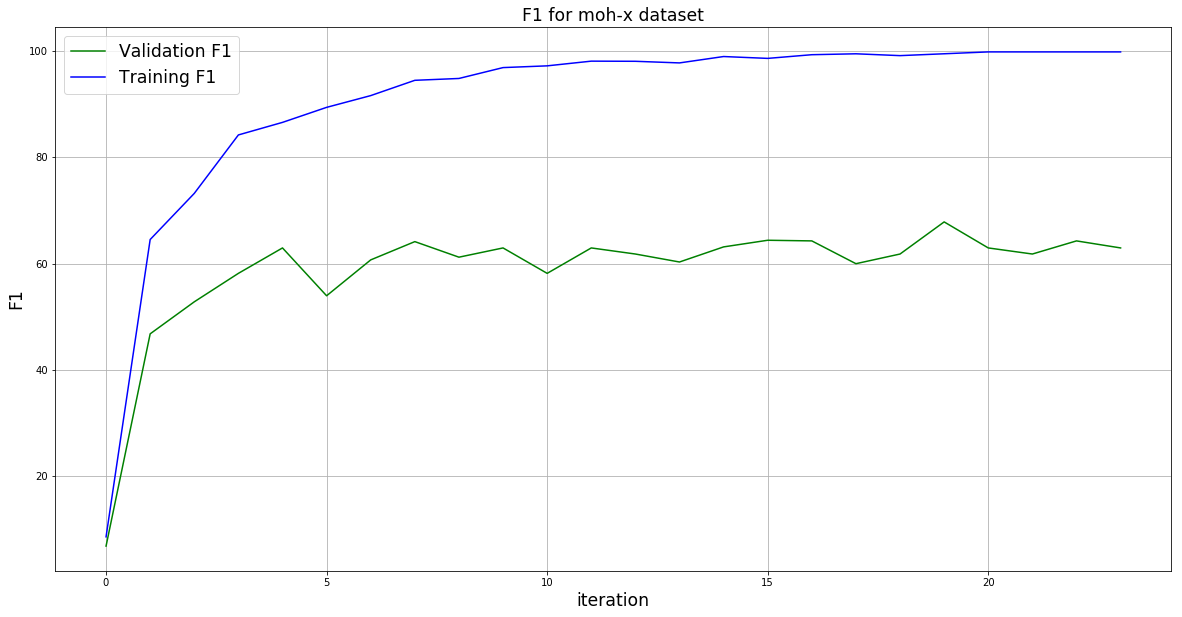

In [43]:
"""
3.3
plot the training process: MET F1 and losses for validation and training dataset
"""
#plt.figure(0)
plt.figure(figsize=(20, 10))
#plt.title('F1 for moh-x dataset on fold ' + str(i))
plt.title('F1 for moh-x dataset', fontsize='xx-large')
plt.xlabel('iteration', fontsize='xx-large')
plt.ylabel('F1', fontsize='xx-large')
plt.plot(val_f1[:-10], 'g')
plt.plot(train_f1[:-10], 'b')
plt.legend(['Validation F1', 'Training F1'], loc='best', fontsize='xx-large')
plt.grid()
plt.show()

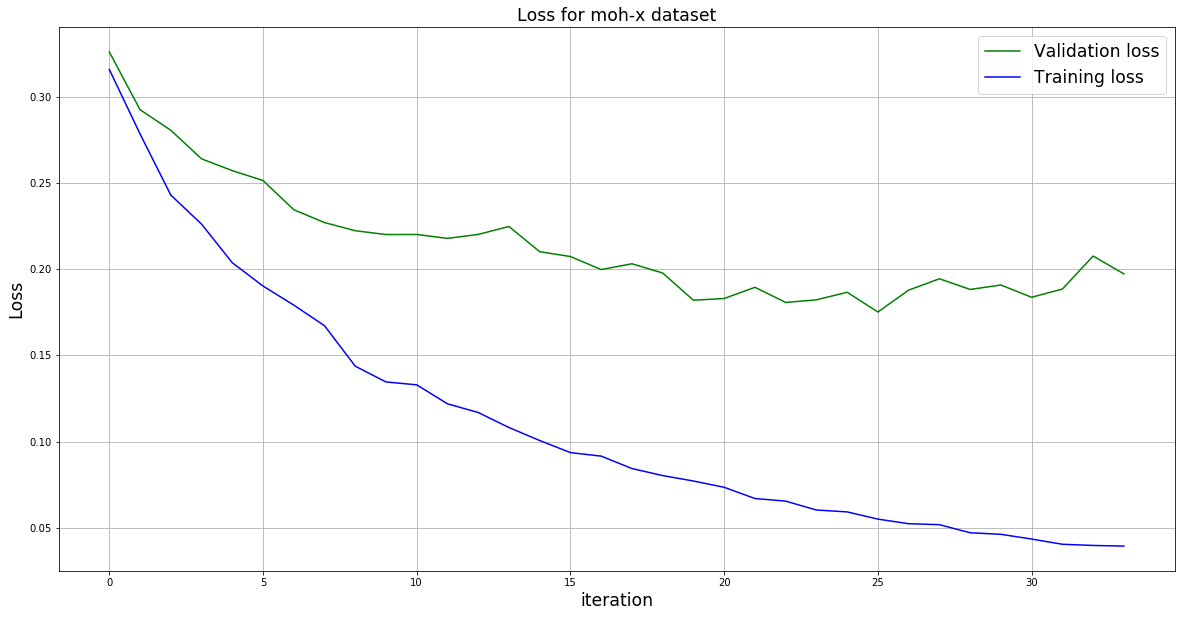

In [45]:
#plt.figure(1)
plt.figure(figsize=(20, 10))
#plt.title('Loss for moh-x dataset on fold ' + str(i))
plt.title('Loss for moh-x dataset', fontsize='xx-large')
plt.xlabel('iteration', fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large')
plt.plot(val_loss, 'g')
plt.plot(train_loss, 'b')
plt.legend(['Validation loss', 'Training loss'], loc='best', fontsize='xx-large')
plt.grid()
plt.show()

In [38]:
"""
store the best f1
"""
print('val_f1: ', val_f1)
idx = 0
if math.isnan(max(val_f1)):
    optimal_f1s.append(max(val_f1[6:]))
    idx = val_f1.index(optimal_f1s[-1])
    optimal_ps.append(val_p[idx])
    optimal_rs.append(val_r[idx])
    optimal_accs.append(val_acc[idx])
else:
    optimal_f1s.append(max(val_f1))
    idx = val_f1.index(optimal_f1s[-1])
    optimal_ps.append(val_p[idx])
    optimal_rs.append(val_r[idx])
    optimal_accs.append(val_acc[idx])

val_f1:  [6.8965517241379315, 46.808510638297875, 52.83018867924528, 58.18181818181818, 62.962962962962955, 53.96825396825397, 60.714285714285715, 64.15094339622641, 61.224489795918366, 62.962962962962955, 58.18181818181818, 62.962962962962955, 61.81818181818181, 60.31746031746032, 63.15789473684211, 64.40677966101696, 64.28571428571429, 60.0, 61.81818181818181, 67.85714285714286, 62.962962962962955, 61.81818181818181, 64.28571428571429, 62.962962962962955, 64.40677966101696, 66.66666666666667, 60.377358490566046, 61.29032258064516, 61.016949152542374, 63.15789473684211, 65.45454545454545, 65.51724137931033, 63.15789473684211, 67.74193548387098]


In [39]:
"""
print out the performance
plot the performance on each fold
"""
print('F1 on MOH-X by 10-fold = ', optimal_f1s)
print('Precision on MOH-X = ', np.mean(np.array(optimal_ps)))
print('Recall on MOH-X = ', np.mean(np.array(optimal_rs)))
print('F1 on MOH-X = ', np.mean(np.array(optimal_f1s)))
print('Accuracy on MOH-X = ', np.mean(np.array(optimal_accs)))

F1 on MOH-X by 10-fold =  [63.15789473684211, 66.66666666666667, 67.85714285714286]
Precision on MOH-X =  64.14203612479474
Recall on MOH-X =  67.85714285714286
F1 on MOH-X =  65.8939014202172
Accuracy on MOH-X =  69.27083333333333


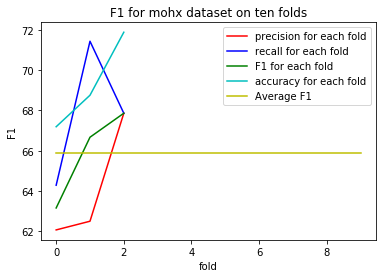

In [40]:
plt.figure(2)
plt.title('F1 for mohx dataset on ten folds')
plt.xlabel('fold')
plt.ylabel('F1')
plt.plot(optimal_ps,'r')
plt.plot(optimal_rs,'b')
plt.plot(optimal_f1s,'g')
plt.plot(optimal_accs,'c')
plt.plot([np.mean(np.array(optimal_f1s))] * 10, 'y')
plt.legend(['precision for each fold', 'recall for each fold', 'F1 for each fold', 'accuracy for each fold', 'Average F1'], loc='upper right')
plt.show()
